In [1]:
#import packages 📦 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import seaborn as sns
import math
import copy
%matplotlib inline

In [2]:
#import more packages 📦 
import keras.backend as K
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

In [3]:
K.clear_session()

In [4]:
#Vgg-face takes data in shape (224,224,3), the RGB channel is on the last axis,
K.set_image_data_format( 'channels_last' ) 
nrow = 224
ncol = 224

In [5]:
#load VGG Face
vggface = VGGFace(model='vgg16') 
vggface.summary()

Metal device set to: Apple M2


2022-11-28 16:21:50.651571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 16:21:50.651652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [6]:
#custom parameters
# 3 Names, 3 classes
nb_class = 17
hidden_dim = 512

vgg_notop = VGGFace(include_top=False, input_shape=(224, 224, 3))
for layer in vgg_notop.layers:
    layer.trainable = False

last_layer = vgg_notop.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)

custom_vgg_model = Model(vgg_notop.input, out)
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [7]:
#training data set
batch_size = 8

train_data_dir = '/Users/cebastiansantiago/Downloads/IN_YOUR_FACE_DATASET/train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 1680 images belonging to 17 classes.


In [8]:
#test data set
test_data_dir = '/Users/cebastiansantiago/Downloads/IN_YOUR_FACE_DATASET/test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                 )
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size, shuffle = False,
                        class_mode='sparse') 

Found 1680 images belonging to 17 classes.


In [9]:
#display image function
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

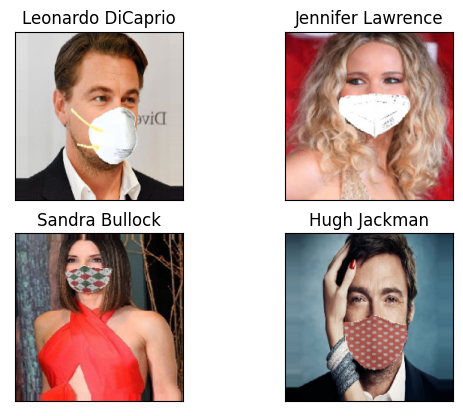

In [11]:

textFileNames = ['Angelina Jolie','Brad Pitt','Denzel Washington','Hugh Jackman','Jennifer Lawrence','Johnny Depp','Kate Winslet','Leonardo DiCaprio','Megan Fox','Natalie Portman','Nicole Kidman','Robert Downey Jr','Sandra Bullock' ,'Scarlett Johansson' ,'Tom Cruise','Tom Hanks'
,'Will Smith']




batch_shape = (batch_size,custom_vgg_model.input_shape[1] , 
               custom_vgg_model.input_shape[2], 
               custom_vgg_model.input_shape[3])
X = np.zeros(batch_shape)
y = np.zeros(batch_size)

X,y = train_generator.next()
nplot = 4        
for i in range(nplot):    
    plt.subplot(2,int(nplot/2),i+1)
    disp_image(X[i,:,:,:])
    title = (textFileNames[int(y[i])])
    plt.title(title)

In [12]:
#train the model
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

/Users/cebastiansantiago/Downloads/ENTER/envs/tflabs/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 120

history = custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/120


/var/folders/kx/3v10kwc567xffx4skmgm48mw0000gn/T/ipykernel_1737/494692246.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = custom_vgg_model.fit_generator(
2022-11-28 16:24:55.334654: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 16:24:55.574393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - ETA: 0s - loss: 2.8304 - accuracy: 0.0631

2022-11-28 16:25:16.214028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

In [ ]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(history)
plotLoss(history)

In [ ]:
names = ['Will Smith','Tom Hanks','Tom Cruise','Scarlett Johansson','Sandra Bullock',
         'Robert Downey JR','Nicole Kidman','Natalie Portman','Megan Fox','Leo','Kate Winslet','Johnny Deep',
        'Jennifier Lawrence','Hugh Jackman','Denzel Washington','Brad Pitt','Angelina Jolie']
#Confusion Matrix 
plt.figure(figsize=(15, 5))

#Predict test images
Y_pred = custom_vgg_model.predict(test_generator)

#Get corresponding predicted label
y_pred = np.argmax(Y_pred, axis=1)

cf = confusion_matrix(test_generator.classes, y_pred)

df_cm = pd.DataFrame(cf, index=names, columns=names)

sns.heatmap(df_cm, annot= True,fmt="d",cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Confusion matrix\n")
plt.show()

In [ ]:
name=np.argmax(Y_pred[0])
print(name)